# Road Lane Detection using FCN (Fully Convolutional Network)

In [1]:
# Import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os  # Add this import

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Training path
train_path = '/kaggle/input/preprocessed-1/tusimple_preprocessed/training'

In [3]:
# Define TensorBoard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='/kaggle/working/tensorboard_logs_1', histogram_freq=1)

# Define ModelCheckpoint callback
model_checkpoint_callback =  keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")


# Combine all callbacks
callbacks = [tensorboard_callback, model_checkpoint_callback]

In [4]:
# Create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)


Found 7252 images belonging to 2 classes.


In [5]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [6]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [7]:
# becacuse of lack of resources like RAM, we only get 2000 training samples
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [8]:
display(X.shape)
display(Y.shape)

(2000, 256, 320, 3)

(2000, 256, 320)

In [9]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [10]:
Y.min(), Y.max()

(0, 1)

In [11]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [12]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [13]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

53

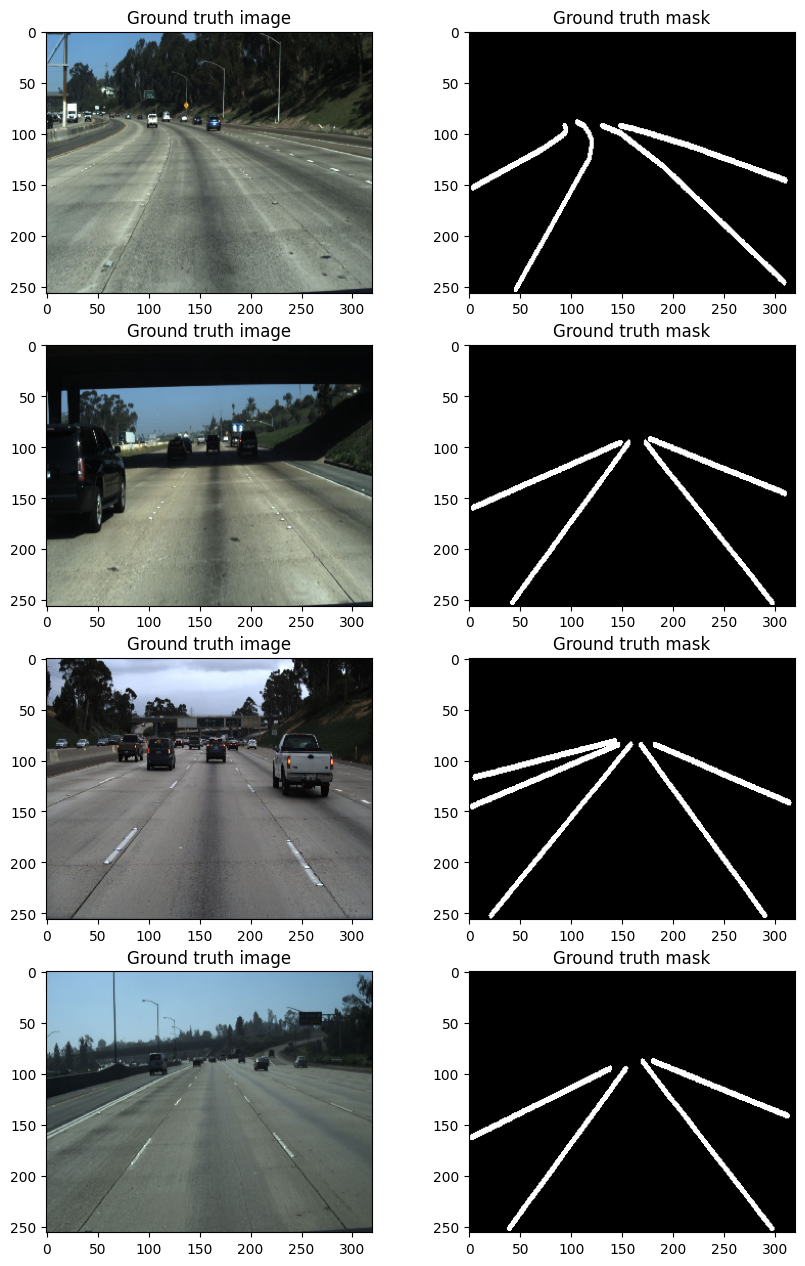

In [14]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [15]:
# model structure
from keras.layers import Input, Conv2DTranspose, Conv2D, MaxPooling2D
from keras.applications.resnet50 import ResNet50

# Define the input shape of the images
input_shape = (256, 320, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

'''
Find the index of the layer named conv3_block4_out of which output size is (32x32xnC)
 because we want to shrink the input's size down upto (32x32xnC) in the encoder section
'''

for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to conv3_block4_out
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
outputs = decoder(encoder(inputs))

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [16]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 320, 3)]     0         
                                                                 
 model (Functional)          (None, 32, 40, 512)       1460096   
                                                                 
 conv2d (Conv2D)             (None, 32, 40, 256)       1179904   
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 80, 256)       262400    
 anspose)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 80, 128)       295040    
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 160, 128)     65664     
 Transpose)                                                

In [17]:
from tensorflow.keras.callbacks import TensorBoard

# Define the folder path to save TensorBoard logs
tensorboard_logs_folder = '/kaggle/working/tensorboard_logs/'

# Create the folder if it doesn't exist
os.makedirs(tensorboard_logs_folder, exist_ok=True)

# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=tensorboard_logs_folder, histogram_freq=1)


# MODEL TRAINING 

In [18]:
# create metrics
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

# train the model
epochs = 32
batch_size = 8
# Train the model with the added TensorBoard callback
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=[tensorboard_callback] + callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/32
225/225 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9631

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 49s 120ms/step - loss: 0.0232 - accuracy: 0.9631 - val_loss: 0.0176 - val_accuracy: 0.9743
Epoch 2/32
225/225 [==============================] - 26s 115ms/step - loss: 0.0144 - accuracy: 0.9770 - val_loss: 0.0150 - val_accuracy: 0.9762
Epoch 3/32
225/225 [==============================] - 26s 117ms/step - loss: 0.0129 - accuracy: 0.9789 - val_loss: 0.0142 - val_accuracy: 0.9777
Epoch 4/32
225/225 [==============================] - 27s 119ms/step - loss: 0.0121 - accuracy: 0.9802 - val_loss: 0.0140 - val_accuracy: 0.9777
Epoch 5/32
225/225 [==============================] - 27s 118ms/step - loss: 0.0113 - accuracy: 0.9813 - val_loss: 0.0144 - val_accuracy: 0.9778
Epoch 6/32
225/225 [==============================] - 27s 118ms/step - loss: 0.0105 - accuracy: 0.9826 - val_loss: 0.0150 - val_accuracy: 0.9774
Epoch 7/32
225/225 [==============================] - 27s 118ms/step - loss: 0.0099 - accuracy: 0.9835 - val_loss: 0.0144 - val_accuracy: 0.9

## METRICS_GRAPH_1

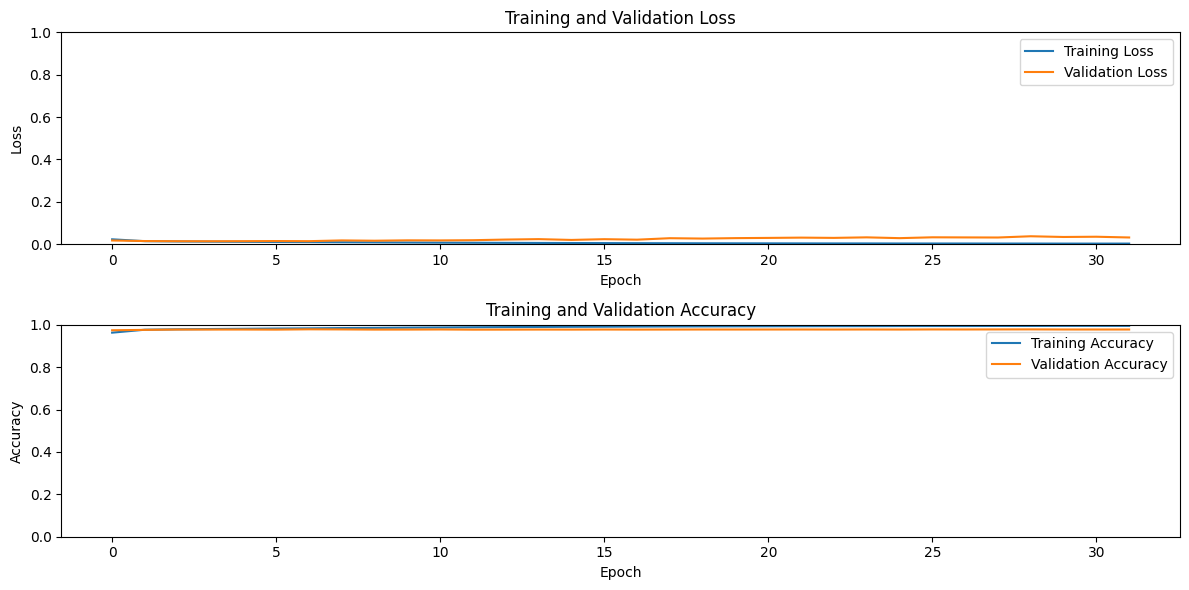

In [19]:
# Plot training and validation metrics in a way that they converge at accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits for loss

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits for accuracy

plt.tight_layout()  # Adjust layout for better visualization

plt.show()


## METRICS_GRAPHS_2

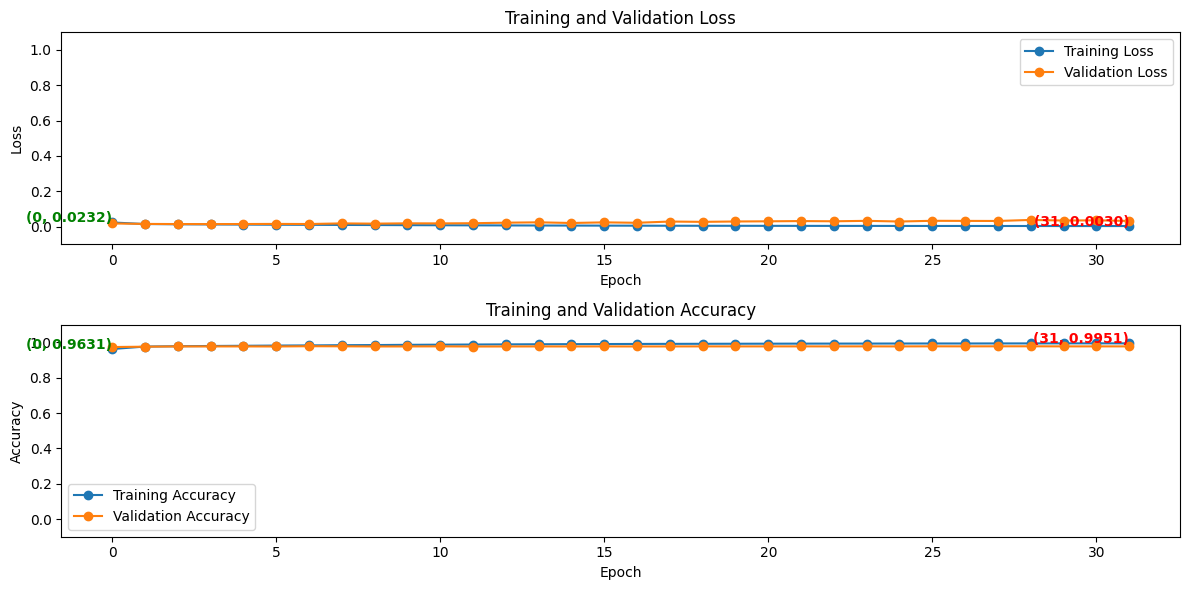

In [20]:
# Plot training and validation metrics with markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (epochs-1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (epochs-1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

plt.show()


In [21]:
preds = model.predict(X_val)
preds.max(), preds.min()

7/7 [==============================] - 5s 139ms/step


(0.99993, 5.240942e-16)

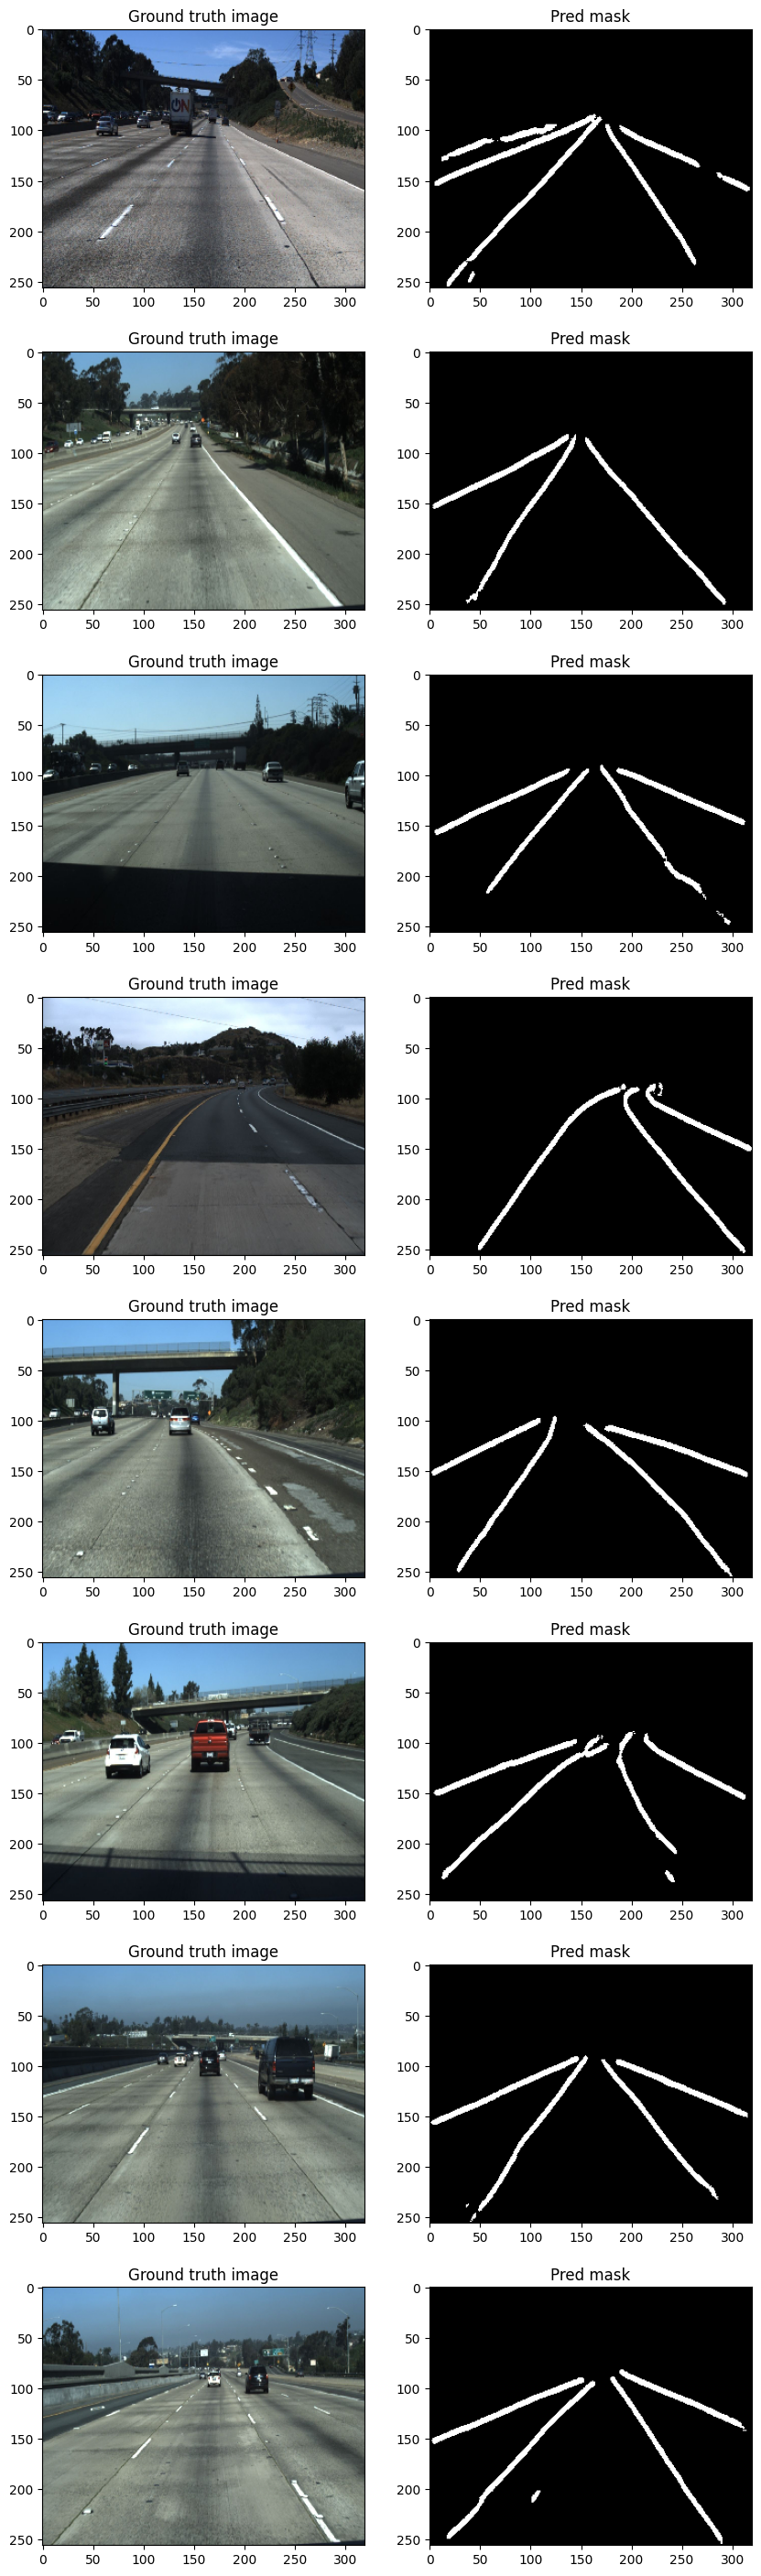

In [22]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [23]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.9779309
Precision: 0.7502751
Recall: 0.73904073
F1 Score:  0.7446155319482949
IoU:  0.59313744


In [24]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
from sklearn.metrics import mean_squared_error
import math
# Calculate MSE
mse_value = mean_squared_error(Y_val.flatten(), preds.flatten())

# Calculate RMSE
rmse_value = math.sqrt(mse_value)
# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recall:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)
# Print the results
print("Mean Squared Error (MSE):", mse_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

Accuracy: 0.9779309
Precision: 0.7502751
Recall: 0.73904073
F1 Score:  0.7446155319482949
IoU:  0.59313744
Mean Squared Error (MSE): 0.022069091796875
Root Mean Squared Error (RMSE): 0.14855669556393275


# GRAPHICAL VISUALIZATION OF METRICS

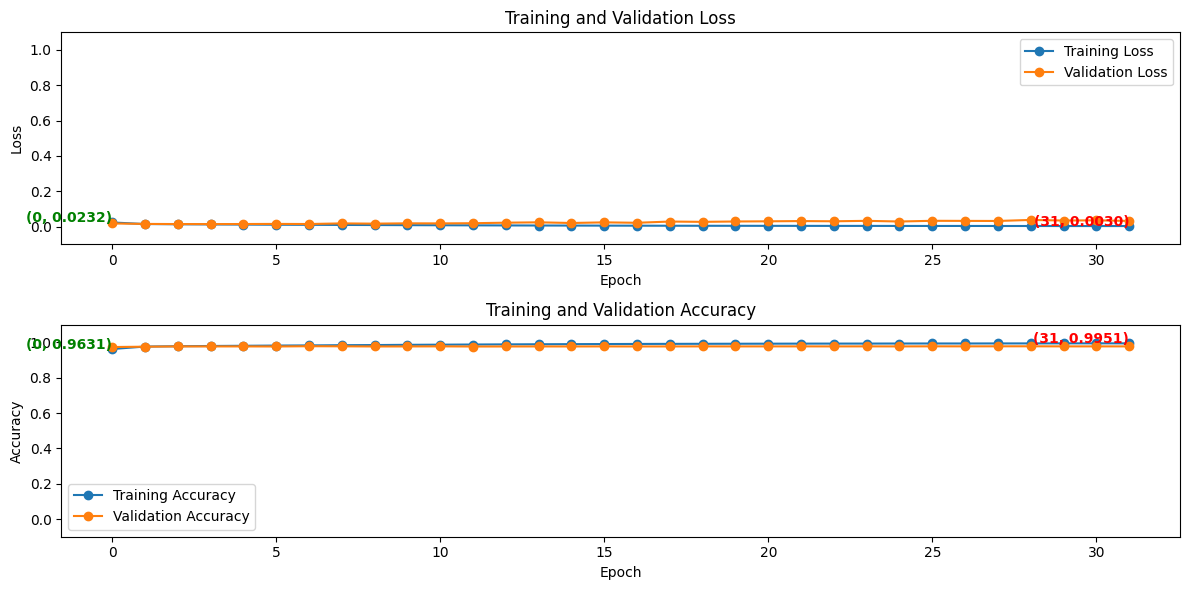

In [25]:
# Plot training and validation metrics with markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (epochs-1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (epochs-1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

plt.show()


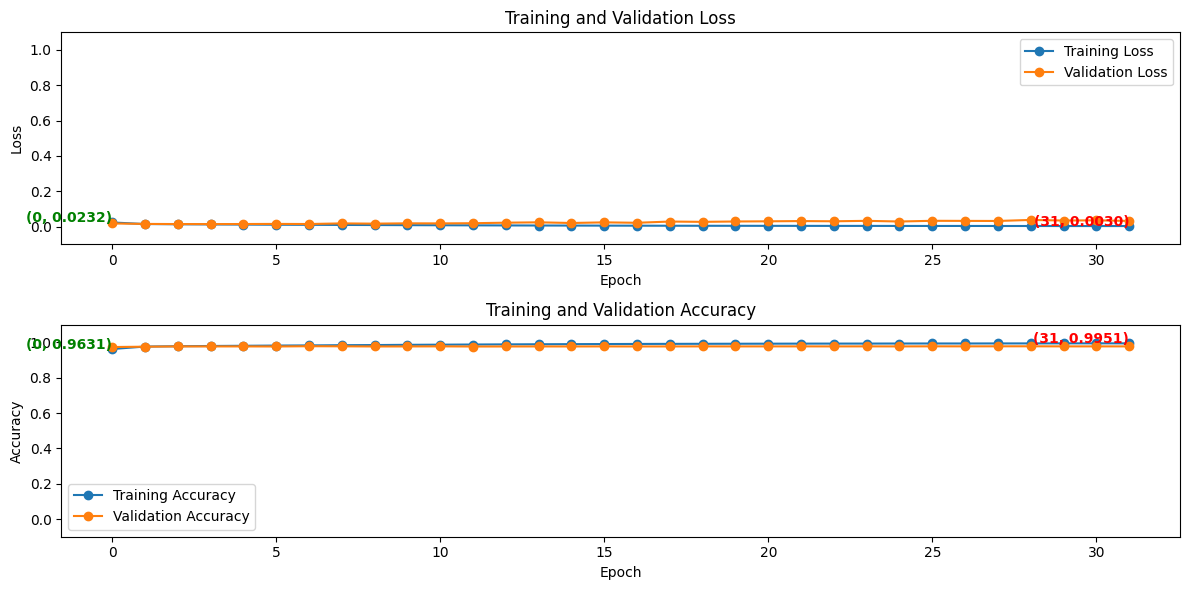

In [26]:
# Plot training and validation metrics with markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (epochs-1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (epochs-1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

# Save the plot to a file
plt.savefig('training_validation_plot.png')

# Show the plot
plt.show()


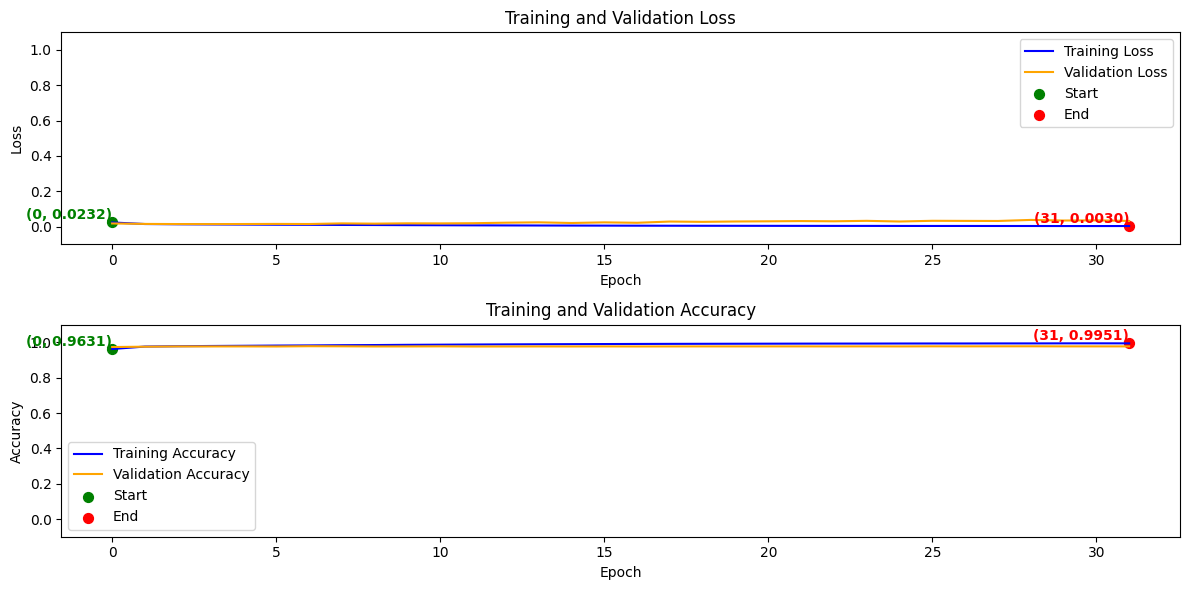

In [27]:
# Plot training and validation metrics with dot markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)  # Two subplots in a vertical arrangement

# Plot without 'o' marker for all epochs
plt.plot(history.history['loss'], label='Training Loss', marker='None', linestyle='-', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='None', linestyle='-', color='orange')

# Dot marker for starting point
plt.scatter(*start_loss_coord, color='green', s=50, label='Start') 

# Dot marker for ending point
plt.scatter(*end_loss_coord, color='red', s=50, label='End')  

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for loss with padding

# Display values for starting and ending points on the loss plot
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize=10, ha='right', va='bottom', weight='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize=10, ha='right', va='bottom', weight='bold')

plt.subplot(2, 1, 2)  # Second subplot for accuracy

# Plot without 'o' marker for all epochs
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='None', linestyle='-', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='None', linestyle='-', color='orange')

# Dot marker for starting point
plt.scatter(*start_accuracy_coord, color='green', s=50, label='Start')  

# Dot marker for ending point
plt.scatter(*end_accuracy_coord, color='red', s=50, label='End')  

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1)  # Set y-axis limits for accuracy with padding

# Display values for starting and ending points on the accuracy plot
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize=10, ha='right', va='bottom', weight='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize=10, ha='right', va='bottom', weight='bold')

plt.tight_layout()  # Adjust layout for better visualization

# Save the plot to a file
plt.savefig('training_validation_plot.png')

# Show the plot
plt.show()


## RECALL CURVE

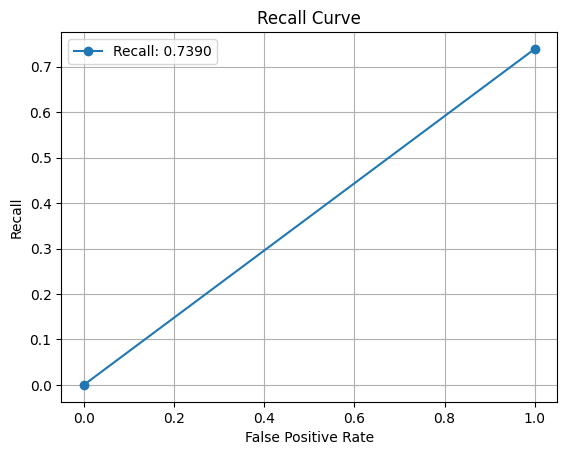

In [28]:
from sklearn.metrics import recall_score

# Calculate recall
recall_val = recall_score(Y_val.flatten(), preds.flatten())

# Plot Recall Curve
plt.plot([0, 1], [0, recall_val], label=f'Recall: {recall_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_curve.png')
plt.show()


## PRECISION CURVE

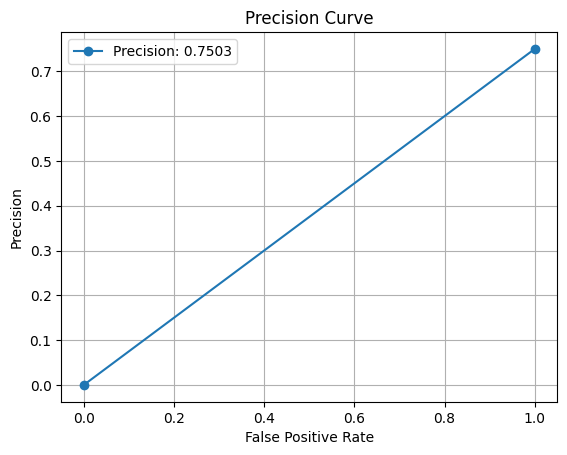

In [29]:
from sklearn.metrics import precision_score

# Calculate precision
precision_val = precision_score(Y_val.flatten(), preds.flatten())

# Plot Precision Curve
plt.plot([0, 1], [0, precision_val], label=f'Precision: {precision_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('precision_curve.png')
plt.show()


## PRECISION-RECALL CURVE

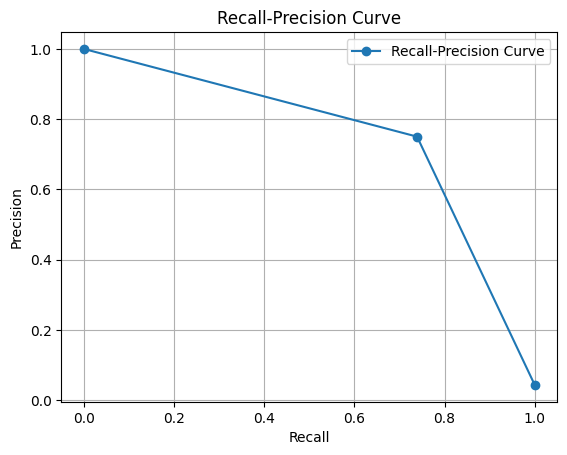

In [30]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(Y_val.flatten(), preds.flatten())

# Plot Recall-Precision Curve
plt.plot(recall, precision, label='Recall-Precision Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()
plt.grid(True)
plt.savefig('recall_precision_curve.png')
plt.show()


## F1 SCORE

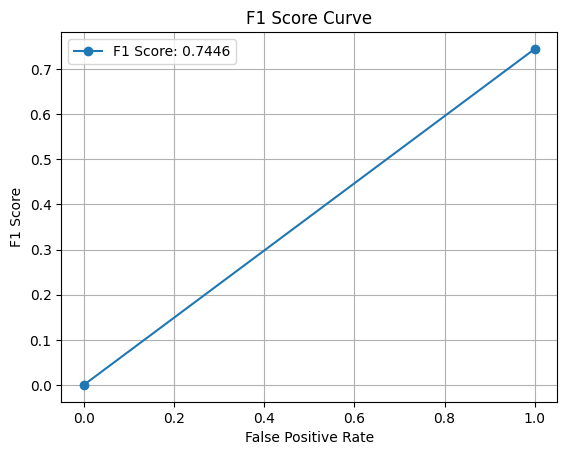

In [31]:
from sklearn.metrics import f1_score

# Calculate F1 Score
f1_score_val = f1_score(Y_val.flatten(), preds.flatten())

# Plot F1 Score Curve
plt.plot([0, 1], [0, f1_score_val], label=f'F1 Score: {f1_score_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_curve.png')
plt.show()


## ACCURACY CURVE

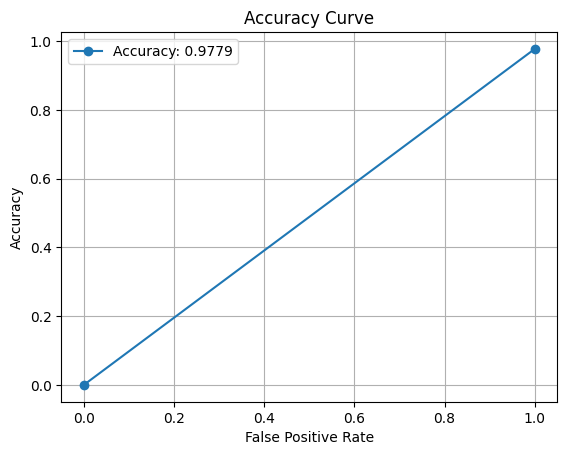

In [32]:
# Plot Accuracy Curve
plt.plot([0, 1], [0, accuracy_value], label=f'Accuracy: {accuracy_value:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.show()


## IoU CURVE

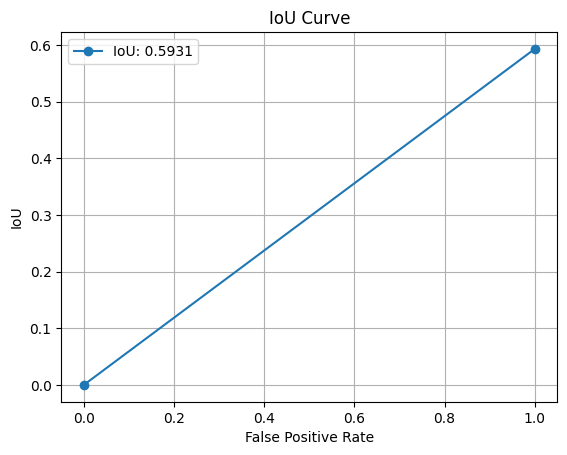

In [33]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_val.flatten(), preds.flatten())

# Calculate True Positive, False Positive, False Negative
tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

# Calculate IoU (Jaccard Index)
iou_val = tp / (tp + fp + fn)

# Plot IoU Curve
plt.plot([0, 1], [0, iou_val], label=f'IoU: {iou_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('IoU')
plt.title('IoU Curve')
plt.legend()
plt.grid(True)
plt.savefig('iou_curve.png')
plt.show()


## PRECISION-RECALL CURVE(WITH VALUES) 

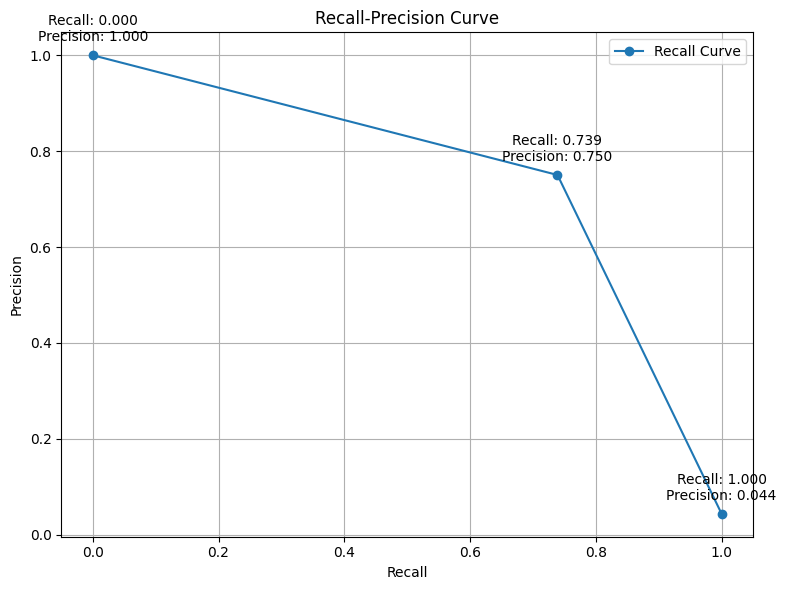

In [34]:
# Plot Recall Curve with values
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Recall Curve', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend()

# Annotate Recall and Precision values on the plot
for i, txt in enumerate(recall):
    plt.annotate(f'Recall: {recall[i]:.3f}\nPrecision: {precision[i]:.3f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the Recall Curve plot
plt.grid(True)
plt.tight_layout()
plt.show()


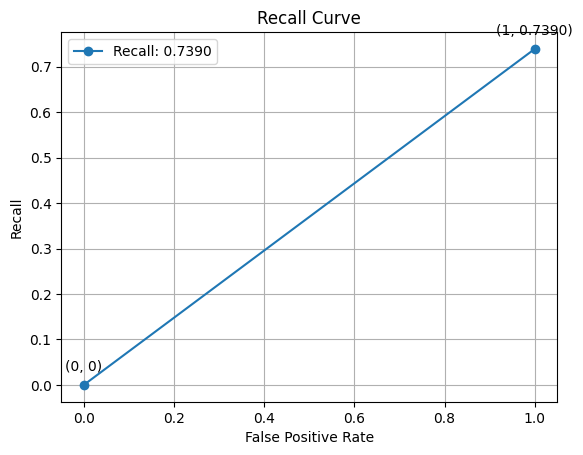

In [35]:
from sklearn.metrics import recall_score

# Calculate recall
recall_val = recall_score(Y_val.flatten(), preds.flatten())

# Plot Recall Curve
plt.plot([0, 1], [0, recall_val], label=f'Recall: {recall_val:.4f}', marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

# Annotate starting and ending point values
plt.annotate(f'(0, 0)', (0, 0), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'(1, {recall_val:.4f})', (1, recall_val), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.savefig('recall_curve.png')
plt.show()


## ROC CURVE

Area Under the Curve (AUC): 0.86


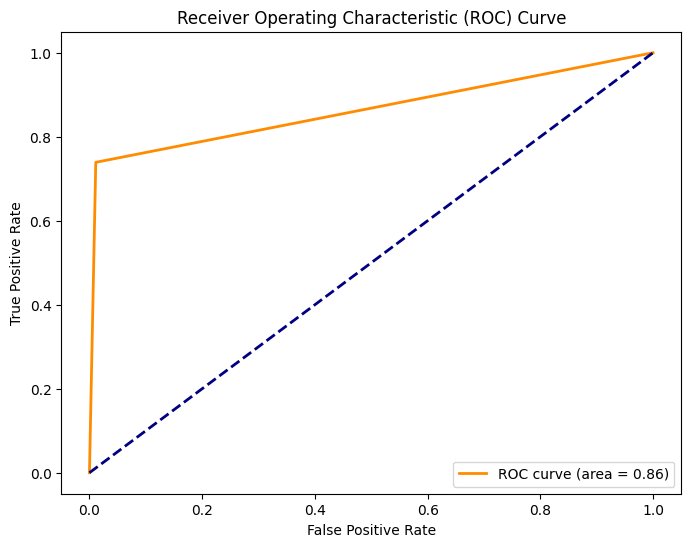

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming preds and Y_val are numpy arrays

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(Y_val.flatten(), preds.flatten())

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Print AUC value
print("Area Under the Curve (AUC): {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
